In [16]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True

import numpy as np
from scipy import integrate
import sympy
sympy.init_printing()

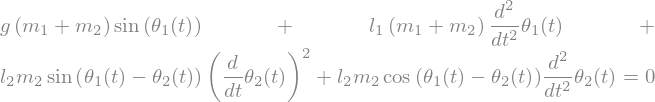

In [18]:
# (m1+m2)l1θ1¨+m2l2θ2¨cos(θ1−θ2)+m2l2(θ2˙)2sin(θ1−θ2)+g(m1+m2)sin(θ1)=0  <-- ode1
# m2l2θ2¨+m2l1θ1¨cos(θ1−θ2)−m2l1(θ1˙)2sin(θ1−θ2)+m2gsin(θ2)=0  <-- ode2

t, g, m1, l1, m2, l2 = sympy.symbols("t, g, m_1, l_1, m_2, l_2") 
theta1, theta2 = sympy.symbols("theta_1, theta_2", cls=sympy.Function) # ode에 사용되는 변수들입니다.

ode1 = sympy.Eq((m1 + m2)*l1*theta1(t).diff(t,t) +
                m2*l2*theta2(t).diff(t,t)*sympy.cos(theta1(t) -theta2(t)) +
                m2*l2*theta2(t).diff(t)**2*sympy.sin(theta1(t) - theta2(t)) + 
                g*(m1 + m2)*sympy.sin(theta1(t)))  # ode1을 정의합니다.
ode1

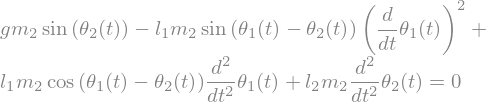

In [19]:
ode2 = sympy.Eq(m2*l2*theta2(t).diff(t,t) +
                m2*l1*theta1(t).diff(t,t)*sympy.cos(theta1(t) - theta2(t)) -
                m2*l1*theta1(t).diff(t)**2*sympy.sin(theta1(t) - theta2(t)) +
                m2*g*sympy.sin(theta2(t))) # ode2를 정의합니다.
ode2

In [20]:
y1, y2, y3, y4 = sympy.symbols("y_1, y_2, y_3, y_4", cls=sympy.Function) # 이차방정식이 2개이므로 일차방정식 4개의 형태로 바꿔서 풀 수 있습니다.

varchange = {theta1(t).diff(t, t): y2(t).diff(t), # theta1을 시간에 대해서 2번 미분한 것 = y2를 시간에 대해서 한번 미분한 것
             theta1(t): y1(t),
             theta2(t).diff(t, t): y4(t).diff(t), # theta2를 시간에 대해서 2번 미분한 것 = y4를 시간에 대해서 한번 미분한 것
             theta2(t): y3(t)}                    # 주어진 것에 따라 변수변환을 해줍니다.

ode1_vc = ode1.subs(varchange)  
ode2_vc = ode2.subs(varchange)
ode3 = y1(t).diff(t) - y2(t)
ode4 = y3(t).diff(t) - y4(t) # 변수변환을 통해 주어진 변형된 변수를 통해 4개의 ode를 만들어줍니다. 문제 1,2

In [21]:
y = sympy.Matrix([y1(t), y2(t), y3(t), y4(t)])
vcsol = sympy.solve((ode1_vc, ode2_vc, ode3, ode4), y.diff(t), dict=True)
f = y.diff(t).subs(vcsol[0])

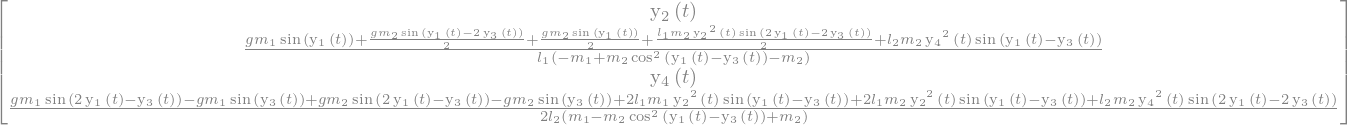

In [22]:
f

In [23]:
jac = sympy.Matrix([[fj.diff(yi) for yi in y] for fj in f]) # 자코비언을 구해줍니다.

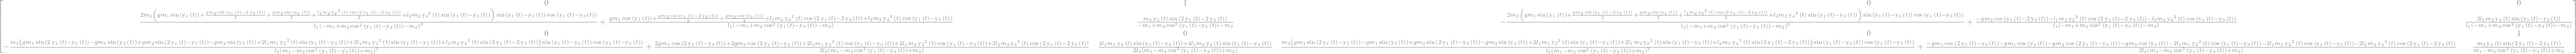

In [24]:
jac

In [25]:
params = {m1: 5.0, l1: 2.0, m2: 1.0, l2: 1.0, g: 9.8} # 각 변수의 값을 정의해줍니다. m = 진자의 무게, l = 길이 , g = 중력가속도

f_np = sympy.lambdify((t, y), f.subs(params), 'numpy')
jac_np = sympy.lambdify((t, y), jac.subs(params), 'numpy')

In [26]:
y0 = [2.0, 0, 0.0, 0]
t = np.linspace(0, 20, 1000)
r = integrate.ode(f_np, jac_np).set_initial_value(y0, t[0])

In [27]:
dt = t[1] - t[0]
y = np.zeros((len(t), len(y0)))
idx = 0
while r.successful() and r.t < t[-1]:
    y[idx, :] = r.y
    r.integrate(r.t + dt)
    idx += 1

In [28]:
theta1_np, theta2_np = y[:, 0], y[:, 2]

x1 =  params[l1] * np.sin(theta1_np)
y1 = -params[l1] * np.cos(theta1_np)
x2 = x1 + params[l2] * np.sin(theta2_np)
y2 = y1 - params[l2] * np.cos(theta2_np) # 얻어진 theta1 , theta2를 이차원 평면 x-y좌표로 바꾸어서 표현합니다.

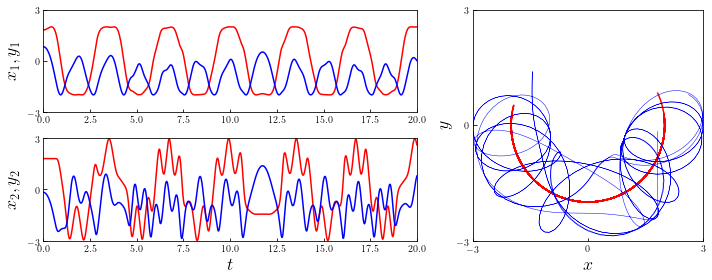

In [29]:
fig = plt.figure(figsize=(10, 4))

ax1 = plt.subplot2grid((2, 5), (0, 0), colspan=3)
ax2 = plt.subplot2grid((2, 5), (1, 0), colspan=3)
ax3 = plt.subplot2grid((2, 5), (0, 3), colspan=2, rowspan=2)

ax1.plot(t, x1, 'r')
ax1.plot(t, y1, 'b')
ax1.set_ylabel('$x_1, y_1$', fontsize=18)
ax1.set_yticks([-3, 0, 3])
ax1.set_xlim(0, 20)
ax1.set_ylim(-3, 3)
ax1.tick_params(which='both', direction='in')

ax2.plot(t, x2, 'r')
ax2.plot(t, y2, 'b')
ax2.set_xlabel('$t$', fontsize=18)
ax2.set_ylabel('$x_2, y_2$', fontsize=18)
ax2.set_yticks([-3, 0, 3])
ax2.set_xlim(0, 20)
ax2.set_ylim(-3, 3)
ax2.tick_params(which='both', direction='in')

ax3.plot(x1, y1, 'r')
ax3.plot(x2, y2, 'b', lw=0.5)
ax3.set_xlabel('$x$', fontsize=18)
ax3.set_ylabel('$y$', fontsize=18)
ax3.set_xticks([-3, 0, 3])
ax3.set_yticks([-3, 0, 3])
ax3.set_xlim(-3, 3)
ax3.set_ylim(-3, 3)
ax3.tick_params(which='both', direction='in')

fig.tight_layout()

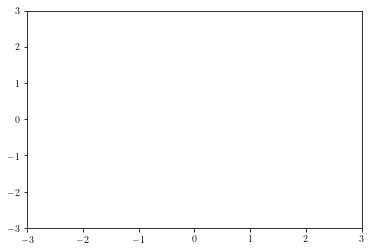

In [42]:
%matplotlib inline
from IPython.display import HTML
from matplotlib import style
from matplotlib.animation import FuncAnimation 

x_data = []
y_data = []

fig, ax = plt.subplots()
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
line, = ax.plot(0,0)

def animation_frame(i):
    x_data.append(i * 10)
    y_data.append(i)
    
    line.set_xdata(x_data)
    line.set_ydata(y_data)
    return line,

animation = FuncAnimation(fig, func=animation_frame, frames=np.arange(0, 10, 0.01), interval=10)
plt.show()